In [1]:
import numpy as np
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io
import pickle

from pymir import pd_utils

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from gradvi.tests import toy_priors
from gradvi.inference import Trendfiltering
from gradvi.models import basis_matrix as gvbm

import sys
sys.path.append('../dsc/functions/')

In [2]:
def stratify_dfcol(df, colname, value):
    return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

In [9]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering"

In [10]:
db = os.path.join(dsc_output, os.path.basename(os.path.normpath(dsc_output)) + ".db")
print(db)

/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering/trendfiltering.db


In [60]:
'''
Target can be any module name, group name
or module.variable
There are two groups of methods, one of them 
needs to be force removed during query (groups = ["fit_cpt:"])
'''

target = ["simulate", "simulate.sfix", "simulate.dtrue", "simulate.n", "fit", "tfmse.err"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]
qp = dscQP(db, target, condition)
qp_df = qp.output_table

df = stratify_dfcols(qp_df, [('simulate.sfix', 16), ('simulate.dtrue', 0), ('DSC', 2)])
df

,DSC,simulate,simulate.sfix,simulate.output.file,simulate.n,simulate.dtrue,fit,fit.output.file,tfmse.err:output
11,2,changepoint,16,changepoint/changepoint_12,1024,0,gradvi_compound_init,gradvi_compound_init/changepoint_12_genlasso_1...,tfmse/changepoint_12_genlasso_1_gradvi_compoun...
101,2,changepoint,16,changepoint/changepoint_12,1024,0,gradvi_compound_scaled,gradvi_compound_scaled/changepoint_12_gradvi_c...,tfmse/changepoint_12_gradvi_compound_scaled_1_...
191,2,changepoint,16,changepoint/changepoint_12,1024,0,gradvi_compound_scaled_init,gradvi_compound_scaled_init/changepoint_12_gen...,tfmse/changepoint_12_genlasso_1_gradvi_compoun...
281,2,changepoint,16,changepoint/changepoint_12,1024,0,mr_ash,mr_ash/changepoint_12_mr_ash_1,tfmse/changepoint_12_mr_ash_1_tfmse_1
371,2,changepoint,16,changepoint/changepoint_12,1024,0,mr_ash_init,mr_ash_init/changepoint_12_genlasso_1_mr_ash_i...,tfmse/changepoint_12_genlasso_1_mr_ash_init_1_...
461,2,changepoint,16,changepoint/changepoint_12,1024,0,mr_ash_scaled,mr_ash_scaled/changepoint_12_mr_ash_scaled_1,tfmse/changepoint_12_mr_ash_scaled_1_tfmse_1
551,2,changepoint,16,changepoint/changepoint_12,1024,0,mr_ash_scaled_init,mr_ash_scaled_init/changepoint_12_genlasso_1_m...,tfmse/changepoint_12_genlasso_1_mr_ash_scaled_...
641,2,changepoint,16,changepoint/changepoint_12,1024,0,gradvi_direct,gradvi_direct/changepoint_12_gradvi_direct_1,tfmse/changepoint_12_gradvi_direct_1_tfmse_1
731,2,changepoint,16,changepoint/changepoint_12,1024,0,gradvi_direct_init,gradvi_direct_init/changepoint_12_genlasso_1_g...,tfmse/changepoint_12_genlasso_1_gradvi_direct_...
821,2,changepoint,16,changepoint/changepoint_12,1024,0,gradvi_compound,gradvi_compound/changepoint_12_gradvi_compound_1,tfmse/changepoint_12_gradvi_compound_1_tfmse_1


In [61]:
data = dsc_io.load_dsc(os.path.join(dsc_output, f"{df['simulate.output.file'].iloc[0]}.pkl"))

In [62]:
methods = df["fit"].unique()
res = dict()
tfmse = dict()
for method in methods:
    dfs = stratify_dfcols(df, [('fit', method)])
    f_ext = "pkl" if method.startswith("gradvi") else "rds"
    resfile = os.path.join(dsc_output, f"{dfs['fit.output.file'].iloc[0]}.{f_ext}")
    res[method] = dsc_io.load_dsc(resfile)
    errfile = os.path.join(dsc_output, f"{dfs['tfmse.err:output'].iloc[0]}.rds")
    tfmse[method] = dsc_io.load_dsc(errfile)['err']

In [63]:
tfmse

{'gradvi_compound_init': 0.0002669593594541302,
 'gradvi_compound_scaled': 0.1878584715321324,
 'gradvi_compound_scaled_init': 0.0002669593594541302,
 'mr_ash': 0.26907443937569364,
 'mr_ash_init': 0.00017297503551801555,
 'mr_ash_scaled': 0.0033592665714036883,
 'mr_ash_scaled_init': 0.0017585945565663386,
 'gradvi_direct': 0.3136861826532643,
 'gradvi_direct_init': 0.00032398464464274867,
 'gradvi_compound': 0.1878584715321324}

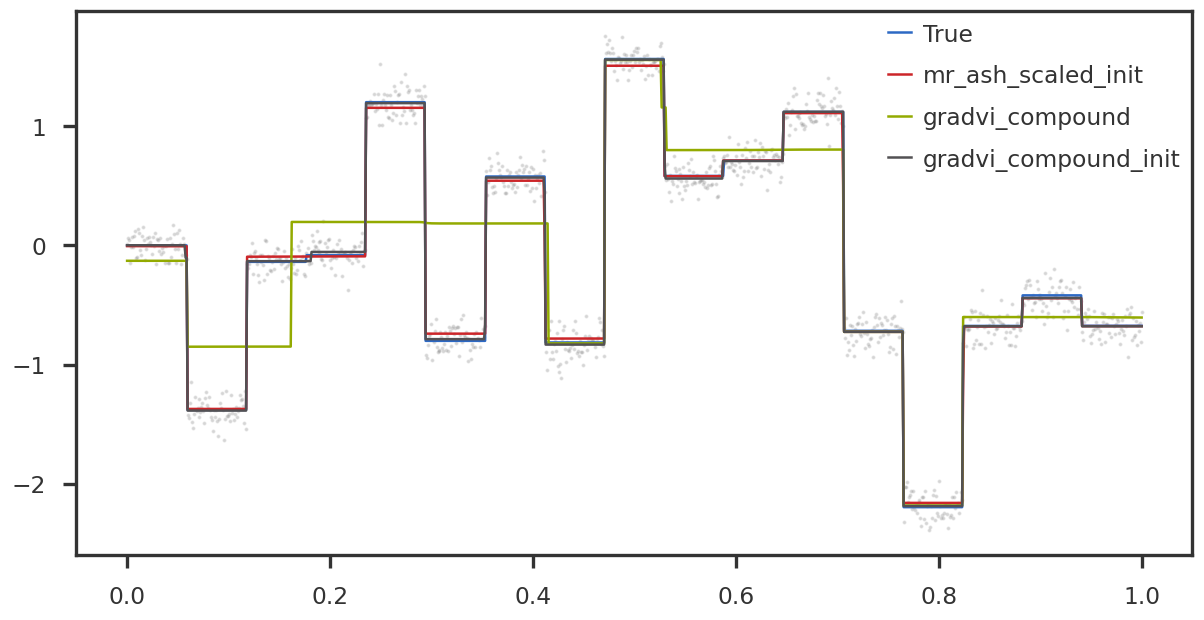

In [65]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)

y = data['y']
ytrue = data['ytrue']
x = np.linspace(0, 1, y.shape[0])

ax1.scatter(x, y, s = 2, color = 'grey', alpha = 0.2)
ax1.plot(x, ytrue, label = 'True')

#for method in ['gradvi_direct', 'gradvi_direct_init', 'gradvi_compound', 'gradvi_compound_init']:
for method in ['mr_ash_scaled_init', 'gradvi_compound', 'gradvi_compound_init']:
    ym = res[method]['ypred']
    ax1.plot(x, ym, label = method)

ax1.legend()
plt.show()

In [55]:
res['mr_ash_init']['model']['fit']['varobj']

array([-319.09091061, -438.27112997, -473.8476835 , ..., -688.42186251,
       -688.42186639, -688.42187025])

In [56]:
res['gradvi_compound']['model']['elbo_path']

array([1636.01923141, 1619.7293942 , 1538.36084404, ..., -166.76258895,
       -166.76261017, -166.76261323])

In [57]:
res['gradvi_compound_init']['model']['elbo_path']

array([-574.30337465, -577.78580401, -582.2076667 , ..., -882.2275207 ,
       -882.22752889, -882.22753259])

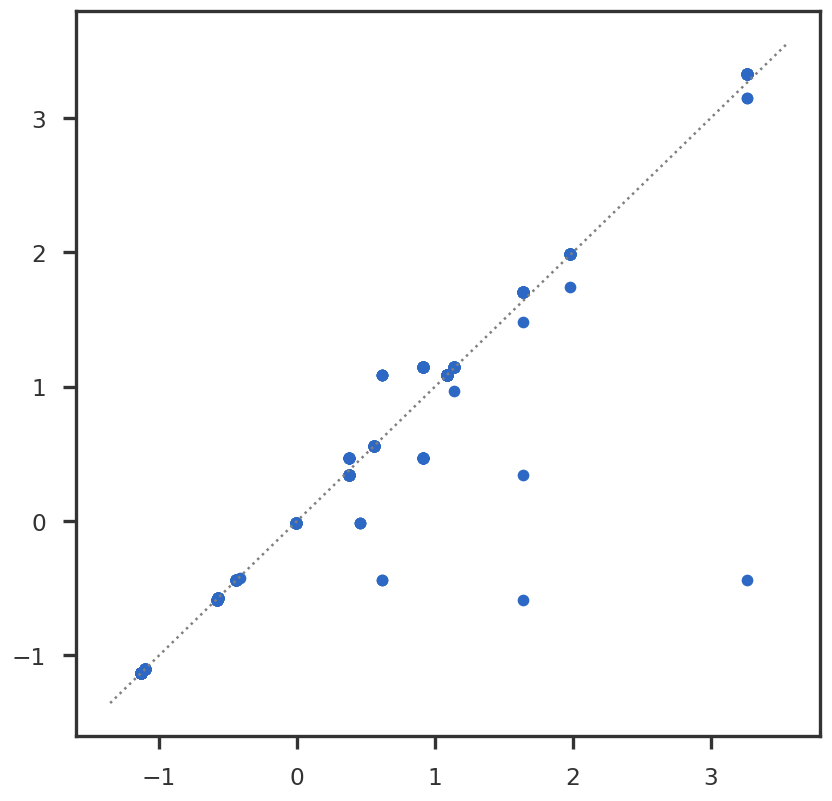

In [58]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

xvals = res['gradvi_compound']['ypred']
yvals = res['gradvi_compound_init']['ypred']
ax1.scatter(xvals, yvals)
mpl_utils.plot_diag(ax1)

plt.show()

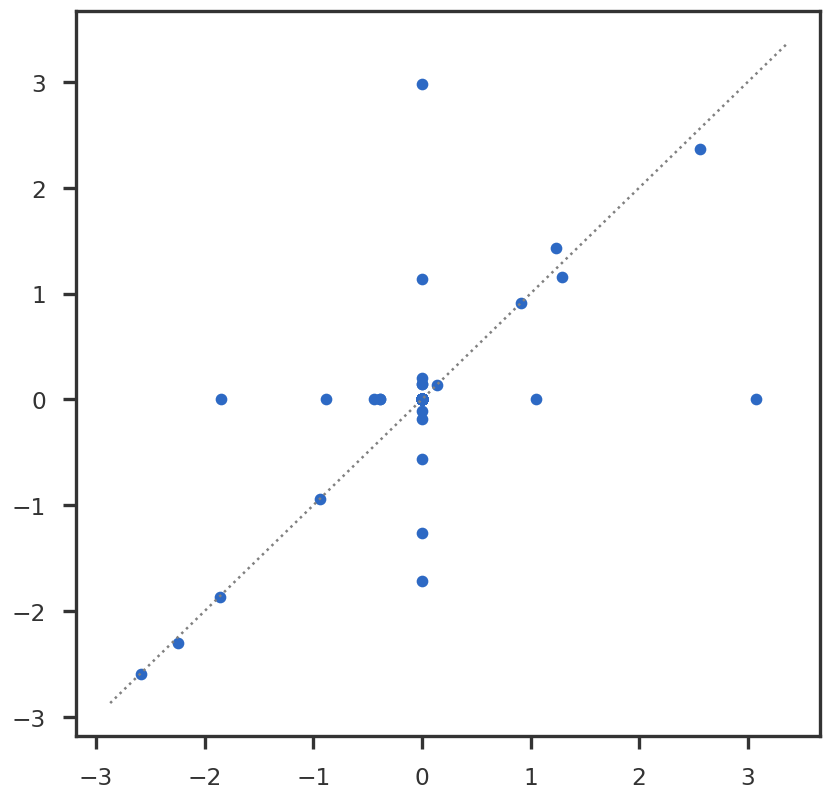

In [59]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

xvals = res['gradvi_compound']['model']['coef'][1:]
yvals = res['gradvi_compound_init']['model']['coef'][1:]
ax1.scatter(xvals, yvals)
mpl_utils.plot_diag(ax1)

plt.show()

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)

y = data['y']
ytrue = data['ytrue']
x = np.linspace(0, 1, y.shape[0])

ax1.scatter(x, y, s = 2, color = 'grey', alpha = 0.2)
ax1.plot(x, ytrue, label = 'True')

for method in ['gradvi_direct', 'gradvi_direct_init']:
    ym = res[method]['ypred']
    ax1.plot(x, ym, label = method)

ax1.legend()
plt.show()